# Experiments, Peeking, and Optimal Stopping

In the decade preceding the Second World War, there was a massive increase in industrial production of war materials, so there was a need to ensure that products, especially munitions, were reliable. The **testing** of war materials is not only **expensive** but also **destructive** since, for example, bullets need to be fired in order to be tested. 

Therefore, the U.S. government was presented with the following **dilemma**: how many bullets should one fire out of a batch before declaring the batch reliable? Clearly, if we were to fire all the bullets, we would know the exact amount of functioning bullets in a crate. However, there would be no bullets left to use.

Because of the growing relevance of these statistical problems, in 1939, a group of prominent statisticians and economists joined forces at Columbia University's [**Statistical Research Group (SGR)**](https://en.wikipedia.org/wiki/The_Statistical_Research_Group_of_World_War_II). The group included, among others, [W. Allen Wallis](https://en.wikipedia.org/wiki/W._Allen_Wallis), [Jacob Wolfowitz](https://en.wikipedia.org/wiki/Jacob_Wolfowitz) and [Abraham Wald](https://en.wikipedia.org/wiki/Abraham_Wald). According to Wallis himself the SGR group was "*composed of what surely must be the most extraordinary group of statisticians ever organized, taking into account both number and quality*"[[2](#References)].

Their work was of first order importance and **classified**, to the point that Wallis reports:

> *It is said that as Wald worked on sequential analysis his pages were snatched away and given a security classification. Being still an "enemy alien", he did not have a security clearance so, the story has it, he was not allowed to know of his results.* [[Wallis (1980)](https://www.jstor.org/stable/2287451)]

Indeed, the group worked under the pressure from the U.S. Army to deliver **fast practical solutions** that could be readily deployed on the field. For example, Wallis reports that

> *during the [Battle of the Bulge](https://en.wikipedia.org/wiki/Battle_of_the_Bulge) in December 1944, several high-ranking Army officers flew to Washington from the battle, spent a day discussing the best settings on proximity fuzes for air bursts of artillery shells against ground troops, and flew back to the battle to put into effect advice from, among others, [Milton Friedman](https://en.wikipedia.org/wiki/Milton_Friedman), whose earlier studies of the fuzes had given him extensive and accurate knowledge of the way the fuzes actually performed.*  [[Wallis (1980)](https://www.jstor.org/stable/2287451)]

The most prominent **result** that came out of the SGR experience was undoubtedly the [Sequential Probability Ratio Test](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test). The idea first came to Wallis and Friedman that realized that

> *it might pay to use a test which would not be as efficient as the classical tests if a sample of exactly N were to be taken, but which would more than offset this disadvantage by providing a good chance of terminating early when used sequentially.* [[Wallis (1980)](https://www.jstor.org/stable/2287451)]

The two economists exposed the idea to the statistician Jacob Wolfowitz who initially

> *seemed to be something distasteful about the idea of people so ignorant of mathematics as Milton and I venturing to meddle with such sacred ideas as those of most powerful statistics, etc. No doubt this antipathy was strengthened by our calling the new tests "supercolossal" on the grounds that they are more powerful than "most powerful" tests.* [[Wallis (1980)](https://www.jstor.org/stable/2287451)]

Ultimately, the two economists managed to draw the attention of both Wolfowitz and Wald that started to formally work on the idea. The results remained top secret until the end of the war when Wald published his [Sequential Tests of Statistical Hypotheses](https://www.jstor.org/stable/2235829) article. 

In this post, after a quick introduction to hypothesis testing, we are going to explore the Sequential Probability Ratio Test and implement it in Python.

## Hypothesis Testing

When we design an A/B test or, more generally, an experiment, the standard steps are the following

1. Define a **null hypothesis** $H_0$, usually a zero effect of the experiment on a metric of interest

    - for example, no effect of a drug on mortality

2. Define a **significance level** $\alpha$, usually equal to 0.05, it represents the maximum probability of rejecting the null hypothesis when it is true

    - for example, the probability of claiming that the drug is effective in reducing mortality, when it's not effective

3. Define an **alternative hypothesis** $H_1$, usually the minimum effect size that we would like to detect

    - for example, a decrease in mortality by 1%
    
4. Define a **power level** $1-\beta$, usually equal to 0.8 ($\beta=0.2$), it represents the minimum probability of rejecting the null hypothesis $H_0$, when the alternative $H_1$ is true

    - for example, the probability of claiming that the drug is ineffective, when it's effective
   
5. Pick a **test statistic** whose distribution is known under both hypotheses, usually the sample average of the metric of interest

    - for example, the average mortality rate of patients
    
6. Compute the minimum **sample size**, in order to achieve the desired power level $1-\beta$, given all the test parameters
    
Then, we **run the test** and, depending on the realized value of the test statistic, we decide whether to **reject** the null hypothesis or not. In particular, we reject the null hypothesis if the **p-value**, i.e. the probability of observing under the null hypothesis a statistic as or more extreme than the sample statistic, is lower than the significance level $\alpha$.

Remember that rejecting the null hypothesis does not imply accepting the alternative hypothesis. 

## Peeking

Suppose that halfway through the experiment we were to **peek at the data** and notice that, for that intermediate value of the test statistic, we would reject the null hypothesis. Should we stop the experiment? If we do, what happens?

The answer is that we **should not stop** the experiment. If we do, the test would not achieve the desired significance level or, in other terms, our confidence intervals would have the **wrong coverage**.

Let's see what I mean with an **example**. Suppose our **data generating process** is a [standard normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) with unknown mean $\mu$ and known variance $\sigma=1$: $X \sim N(\mu,1)$. 

The **hypothesis** that we wish to test is

$$
\begin{align}
H_0: \quad & \mu = 0
\newline
H_1: \quad & \mu = 0.1
\end{align}
$$

After each observation $n$, we compute the [**z test statistic**](https://en.wikipedia.org/wiki/Z-test) 

$$
z = \frac{\bar X_n - \mu_0}{\frac{\sigma}{\sqrt{n}}} = \frac{\bar X_n - 0}{\frac{1}{\sqrt{n}}} = \bar X_n * \sqrt{n}
$$ 

where $\bar X_n$ is the [sample mean](https://en.wikipedia.org/wiki/Sample_mean_and_covariance) from a sample $X_1, X_2, ..., X_n$, of size $n$, $\sigma$ is the standard deviation of the population, and $\mu_0$ is the population mean, under the null hypothesis. The term in the denominator, $\frac{\sigma}{\sqrt{n}}$, is the variance of the sample mean. Under the null hypothesis of zero mean, the test statistic is distributed as a standard normal distribution with zero mean and unit variance, $N(0,1)$.

Let's code the test in Python. I import some code from [`utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/utils.py) to make the plots prettier.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

zstat = lambda x: np.mean(x) * np.sqrt(len(x))
zstat.__name__ = 'z-statistic'

Suppose we want a test with significance level $\alpha=0.05$ and power $1-\beta=0.8$. What sample size $n$ do we need?

We need a sample size such that 

1. The probability of rejecting the null hypothesis $H_0$, when $H_0$ is *true*, is at most $\alpha=0.05$
2. The probability of *not* rejecting the null hypothesis $H_0$, when $H_0$ is *false* (i.e. $H_1$ is true), is at most $\beta=0.2$

I.e. we need to find a **critical value** $c$ such that

1. $c = \mu_0 + z_{0.95} * \frac{\sigma}{\sqrt{n}}$
2. $c = \mu_1 - z_{0.8} * \frac{\sigma}{\sqrt{n}}$

where $z_{p}$ is the CDF inverse (or [percent point function](https://en.wikipedia.org/wiki/Quantile_function)) at $p$, and $\mu_i$ are the values of the mean under the different hypotheses.

Combining the two expressions together we can solve for the **required minimum sample size**.

$$
n : \mu_0 + z_{0.95} * \frac{\sigma}{\sqrt{n}} = \mu_1 - z_{0.8} * \frac{\sigma}{\sqrt{n}}
$$

so that

$$
n = \left( \sigma * \frac{z_{0.95} + z_{0.8}}{\mu_0 + \mu_1} \right)^2 = \left( 1 * \frac{1.64 + 0.84}{0 + 0.1} \right)^2 = 618.25
$$

In [3]:
from scipy.stats import norm

n = ( (norm.ppf(0.95) + norm.ppf(0.8)) / 0.1 )**2
print(f"Minimum sample size: {n}")

Minimum sample size: 618.2557232019765


We need at least 619 observations.

We can get a better **intuition** by graphically plotting the two distributions with the critical value. I wrote a function [`plot_test`](https://github.com/matteocourthoud/Blog-Posts/blob/main/src/figures.py) to draw a standard hypothesis testing setting.

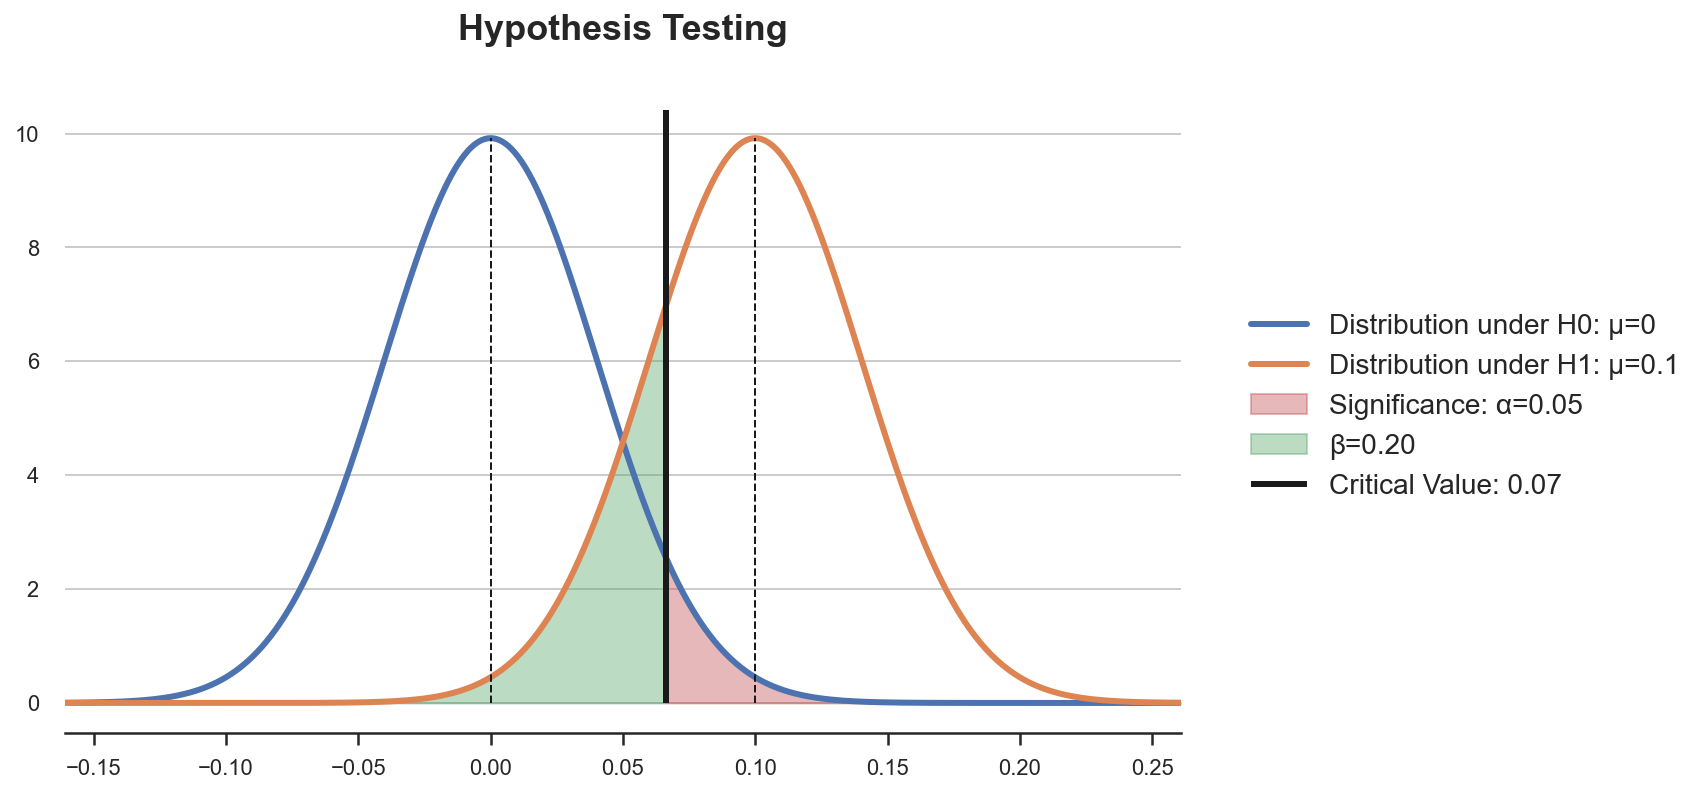

In [4]:
from src.figures import plot_test

plot_test(mu0=0, mu1=0.1, alpha=0.05, n=n)

The critical value is such that, given the distributions under the two hypothesis, the **rejection area** in red is equal to $\alpha$. The sample size $n$ is such that it shrinks the variance of the two distributions so that the area in green is equal to $\beta$.

Let's now **simulate an experiment** in which we draw an ordered sequence of observations and, after each observation, we compute the value of the test statistic.

In [5]:
def experiment(f_stat, mu=0, n=619, seed=1):
    np.random.seed(seed) # Set seed
    I = np.arange(1, n+1) # Observation index
    x = np.random.normal(mu, 1, n) # Observation value
    stat = [f_stat(x[:i]) for i in I] # Value of the test statistic so far
    df = pd.DataFrame({'i': I, 'x': x, f_stat.__name__: stat}) # Generate dataframe
    return df

Let's have a look at what a sample looks like.

In [6]:
df = experiment(zstat)
df.head()

,i,x,z-statistic
0,1,1.624345,1.624345
1,2,-0.611756,0.716009
2,3,-0.528172,0.279678
3,4,-1.072969,-0.294276
4,5,0.865408,0.123814


We can now plot the time trend of the test statistic as we accumulate observations during the sampling process. I also mark with horizontal lines the values for rejection of the null hypothesis of a test with $\alpha = 0.05$: $z_{0.025} = -1.96$ and $z_{0.975} = 1.96$.

In [7]:
def plot_experiment(df, ybounds, **kwargs):
    sns.lineplot(data=df, x='i', y=df.columns[2], **kwargs)
    for ybound in ybounds:
        sns.lineplot(x=df['i'], y=ybound, lw=1.5, color='black')
    plt.title(f'{df.columns[2]} with sequential sampling')
    plt.yticks([0, ybounds[0], ybounds[1]])

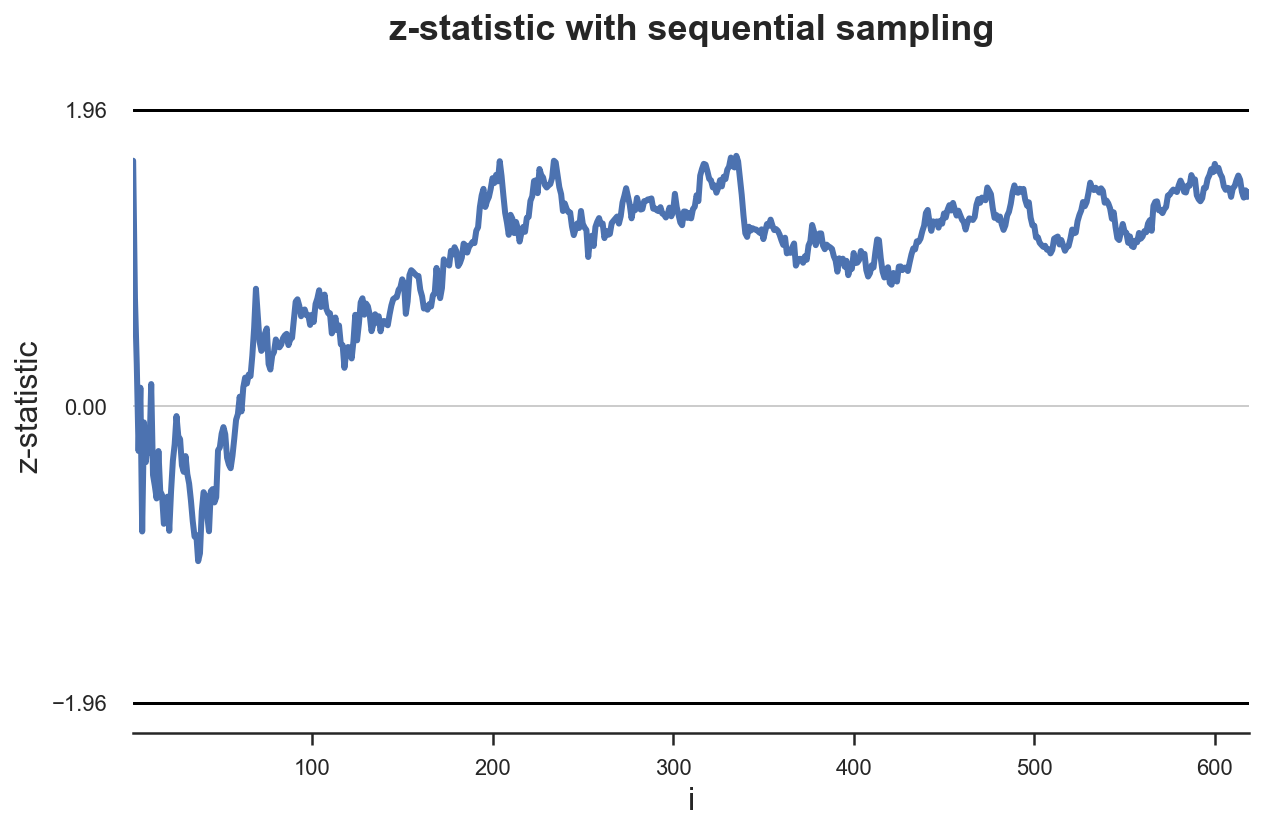

In [8]:
plot_experiment(df, ybounds=[-1.96, 1.96])

In this case, the test never crosses the critical values. Therefore, peeking does not have an effect. We would not have stopped the experiment prematurely. 

What would happen if we were **repeating** the experiment many times? Since the data is generated under the null hypothesis, $H_0: \mu = 0$, we expect to reject it only $\alpha=5\%$ of the times. 

Let's simulate the data-generating process $K=100$ times.

In [9]:
def simulate_experiments(f_stat, ybounds, xmin=0, early_stop=False, mu=0, K=100, n=619, **kwargs):
    # Count experiment durations
    stops = np.zeros(K) * n
    
    # Perform K simulations
    for k in range(K):
        # Draw data
        df = experiment(f_stat, mu=mu, seed=k, n=n)
        vals = df[f_stat.__name__].values
        
        # If early stop, check early violations (during sampling)
        if early_stop:
            violations = (vals[xmin:] > max(ybounds)) + (vals[xmin:] < min(ybounds))
        if early_stop and any(violations):
            end = 1 + xmin + np.where(violations)[0][0]
            plot_experiment(df.iloc[:end, :], ybounds, **kwargs)
            stops[k] = end * np.sign(df[f_stat.__name__].values[end])
        
        # Otherwise, only check violations of last value
        elif (vals[-1] > max(ybounds)) or (vals[-1] < min(ybounds)):
            plot_experiment(df, ybounds, **kwargs)
            stops[k] = len(df) * np.sign(vals[-1])
        
        # Plot all other observations in grey
        else: 
            plot_experiment(df, ybounds, color='grey', alpha=0.1, lw=1)
    
    # Print diagnostics
    pct_up = sum(stops>0)/sum(stops!=0)*100
    print(f'Bounds crossed: {sum(stops!=0)} ({pct_up:.0f}% upper, {100-pct_up:.0f}% lower)')
    print(f'Average experiment duration: {(sum(np.abs(stops)) + n*sum(stops==0))/ len(stops) :.0f}')

We plot the distribution of the z-statistic over samples .

Bounds crossed: 3 (33% upper, 67% lower)
Average experiment duration: 619


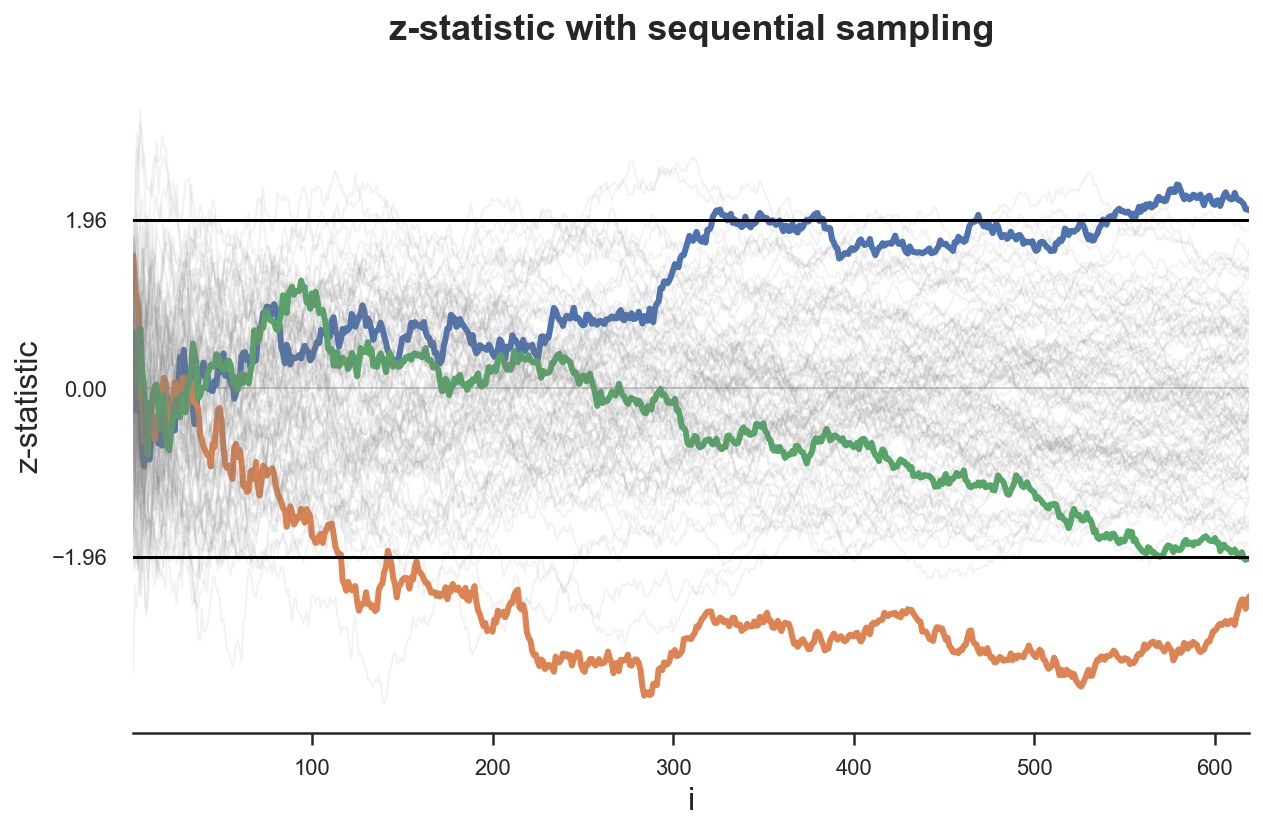

In [10]:
simulate_experiments(zstat, ybounds=[-1.96, 1.96], early_stop=False);

In the figure above, I have highlighted the experiments for which we reject the null hypothesis **without peeking**, i.e. given the value of the z test statistic **at the end of the sampling** process. Only in 3 experiments the final value lies outside the critical values, so that we reject the null hypothesis. This means a **rejection rate** of 3% which is very close to the expected rejection rate of $\alpha=0.05$ (under the null). 

What if instead we were **impatient** and, after collecting the first 100 observations, we were stopping **as soon as** we saw the z-statistic crossing the boundaries?

Bounds crossed: 25 (48% upper, 52% lower)
Average experiment duration: 523


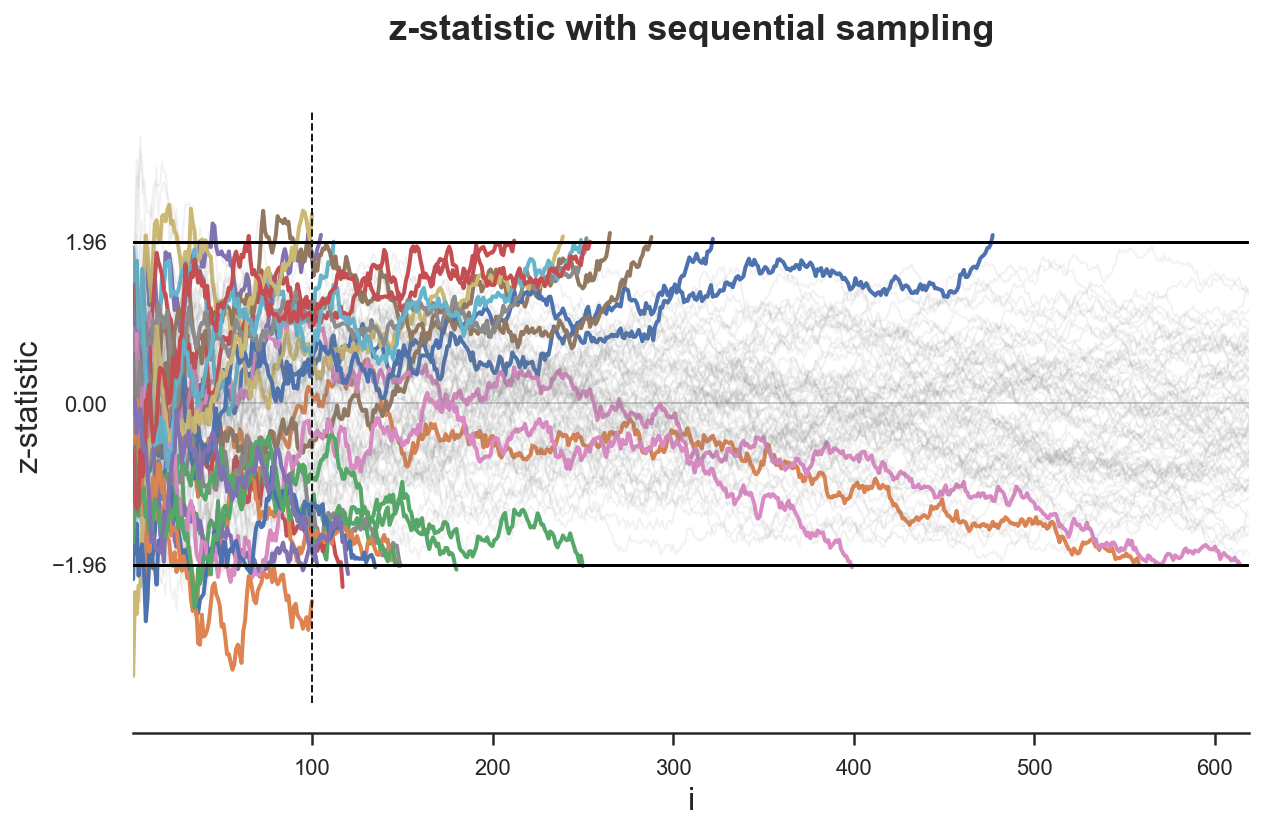

In [11]:
stops_zstat_h0 = simulate_experiments(zstsat, xmin=99, ybounds=[-1.96, 1.96], early_stop=True, lw=2);
plt.vlines(100, ymin=plt.ylim()[0], ymax=plt.ylim()[1], color='k', lw=1, ls='--');

In the figure above, I have highlighted the experiments in which the values of the z-statistic crosses one of the boundaries, from the 100th observation onwards. This happens in 25 simulations out of 100, which implies a **rejection rate** of 25%, which is very far from the expected rejection rate of $\alpha=0.05$ (under the null hypothesis). Peaking **distorts** the significance level of the test.

Potential solutions are:

1. **sequential probability ratio tests**
2. **sequential triangular testing**
3. **group sequential testing**

Before analyzing these sequential testing procedures, we first need to introduce the **likelihood ratio test**.

## Likelihood Ratio Test

The likelihood ratio test is a test that tries to assess the likelihood that the observed data was generated by either one of two competing statistical models. 

In order to perform the likelihood ratio test for hypothesis testing, we need the data generating process to be fully specified under both hypotheses. For example, this would be the case with the following hypotheses:

$$
\begin{align}
H_0: \quad & \mu=0
\newline
H_1: \quad & \mu=0.1
\end{align}
$$

In this case, we say that the statistical test is fully specified. If the alternative hypothesis was $H_1: \mu \neq 0$, then the data generating process would not be specified under the alternative hypothesis. 

When a statistical test is fully specified, we can compute the likelihood ratio as the the ratio of the [likelihood function](https://en.wikipedia.org/wiki/Likelihood_function) under the two hypotheses.

$$
\Lambda (X) = \frac{\mathcal L (\theta_1 \ | \ X)}{\mathcal L (\theta_0 \ | \ X)}
$$

The likelihood-ratio test provides a decision rule as follows:

- If $\Lambda>c$, reject $H_{0}$;
- If $\Lambda<c$, do not reject $H_{0}$;
- If $\Lambda =c$, reject with probability $q$ 

The values $c$ and $q$ are usually chosen to obtain a specified significance level $\alpha$.

The [**Neyman–Pearson lemma**](https://en.wikipedia.org/wiki/Neyman%E2%80%93Pearson_lemma) states that this likelihood-ratio test is the most powerful among all level $\alpha$ tests for this case.

### Special Case: testing mean of normal distribution

Let's go back to our example where data is coming from a normal distribution with unknown mean $\mu$ and known variance $\sigma^2$ and we want to perform the following test

$$
\begin{align}
H_0: \quad & \mu = 0 ,
\newline
H_1: \quad & \mu = 0.1
\end{align}
$$

The likelihood of the normal distribution with unknown mean $\mu$ and known variance $\sigma^2$ is

$$
\mathcal L(\mu) = \left( \frac{1}{\sqrt{2 \pi} \sigma } \right)^n e^{- \sum_{i=1}^{n} \frac{(X_i - \mu)^2}{2 \sigma^2}}
$$

So that the likelihood ratio under the two hypotheses is

$$
\Lambda(X) = \frac{\mathcal L (0.1, \sigma^2)}{\mathcal L (0, \sigma^2)} = \frac{e^{- \sum_{i=1}^{n} \frac{(X_i - 0.1)^2}{2 \sigma^2}}}{e^{- \sum_{i=1}^{n} \frac{(X_i)^2}{2 \sigma^2}}}
$$

We now have all the ingredients to move on to the final purpose of this blog post: the Sequential Probability Ratio Test.

## Sequential Probability Ratio Test

Given a pair of fully specified hypotheses, say $H_{0}$ and $H_{1}$, the **first step** of the sequential probability ratio test is to calculate the log-likelihood ratio test $\log (\Lambda_{i})$, as new data arrive: with $S_{0}=0$, then, for $i=1,2,...,$

$$
S_{i} = S_{i-1} + \log(\Lambda_{i})
$$

The stopping rule is a simple thresholding scheme:

- $S_{i}\geq b$: Accept $H_{1}$
- $S_{i}\leq a$: Accept $H_{0}$
- $a<S_{i}<b$: continue monitoring (critical inequality)

where $a$ and $b$ ($-\infty<a<0<b<\infty$) depend on the desired type I and type II errors, $\alpha$  and $\beta$. 

[Wald (1945)](https://www.jstor.org/stable/2235829) shows that the choice of the following boundaries delivers a test with expected probability of type 1 and 2 error not greater than $\alpha$ and $\beta$, respectively.

$$
a \approx \log {\frac  {\beta }{1-\alpha }} \quad \text{and} \quad  b \approx \log {\frac  {1-\beta }{\alpha }}
$$

The equations are approximations because of the discrete nature of the data generating process.

[Wald and Wolfowitz (1948)](https://www.jstor.org/stable/2235638) have proven that a test with these boundaries is the most powerful sequential probability ratio test, i.e. all SPR tests with the same power and significance require at least the same amount of observations.

### Special Case: testing null effect

Let's go back to our example where data is coming from a normal distribution with unknown mean $\mu$ and known variance $\sigma^2$ and hypotheses $H_0: \ \mu = 0$ and $H_1: \ \mu = 0.1$.

We have seen that the likelihood ratio with a sample of size $n$ is 

$$
\Lambda(X) = \frac{\mathcal L (0.1, \sigma^2)}{\mathcal L (0, \sigma^2)} = \frac{e^{- \sum_{i=1}^{n} \frac{(X_i - 0.1)^2}{2 \sigma^2}}}{e^{- \sum_{i=1}^{n} \frac{(X_i)^2}{2 \sigma^2}}}
$$

Therefore, the log-likelihood (easier to compute) is

$$
\log (\Lambda(X)) = \left( \sum_{i=1}^{n} \frac{(X_i)^2}{2 \sigma^2} \right) - \left( \sum_{i=1}^{n} \frac{(X_i - 0.1)^2}{2 \sigma^2} \right)
$$

### Simulation

We are now ready to perform some simulations. First, let's code the **log likelihood ratio test statistic** that we have just computed.

In [23]:
log_lr = lambda x: (np.sum((x)**2) - np.sum((x-0.1)**2) ) / 2
log_lr.__name__ = 'log likelihood-ratio'

We now repeat the same experiment we did at the beginning, with one difference: we will compute the log likelihood ratio as a statistic. The data generating process has $\mu=0$, as under the null hypothesis.

In [32]:
df = experiment(log_lr, )
df.head()

,i,x,log likelihood-ratio
0,1,1.624345,0.157435
1,2,-0.611756,0.091259
2,3,-0.528172,0.033442
3,4,-1.072969,-0.078855
4,5,0.865408,0.002686


Let's now compute the optimal bounds, given significance level $\alpha=0.05$ and power $1-\beta=0.8$. 

In [25]:
alpha = 0.05
beta = 0.2

a = np.log( beta / (1-alpha) )
b = np.log( (1-beta) / alpha )
print(f'Optimal bounds : [{a:.3f}, {b:.3f}]')

Optimal bounds : [-1.558, 2.773]


Since significance and (one minus) power are different, the bound for the null hypothesis is much **closer** than the bound for the alternative hypothesis. This means that, in case of an intermediate effect of $\mu=0.05$, we will be more likely to accept the null hypothesis $H_0: \mu = 0$ than the alternative $H_1: \mu = 0.1$.

We can plot the distribution of the likelihood ratio over samples drawn under the null hypothesis $H_0: \mu = 0$.

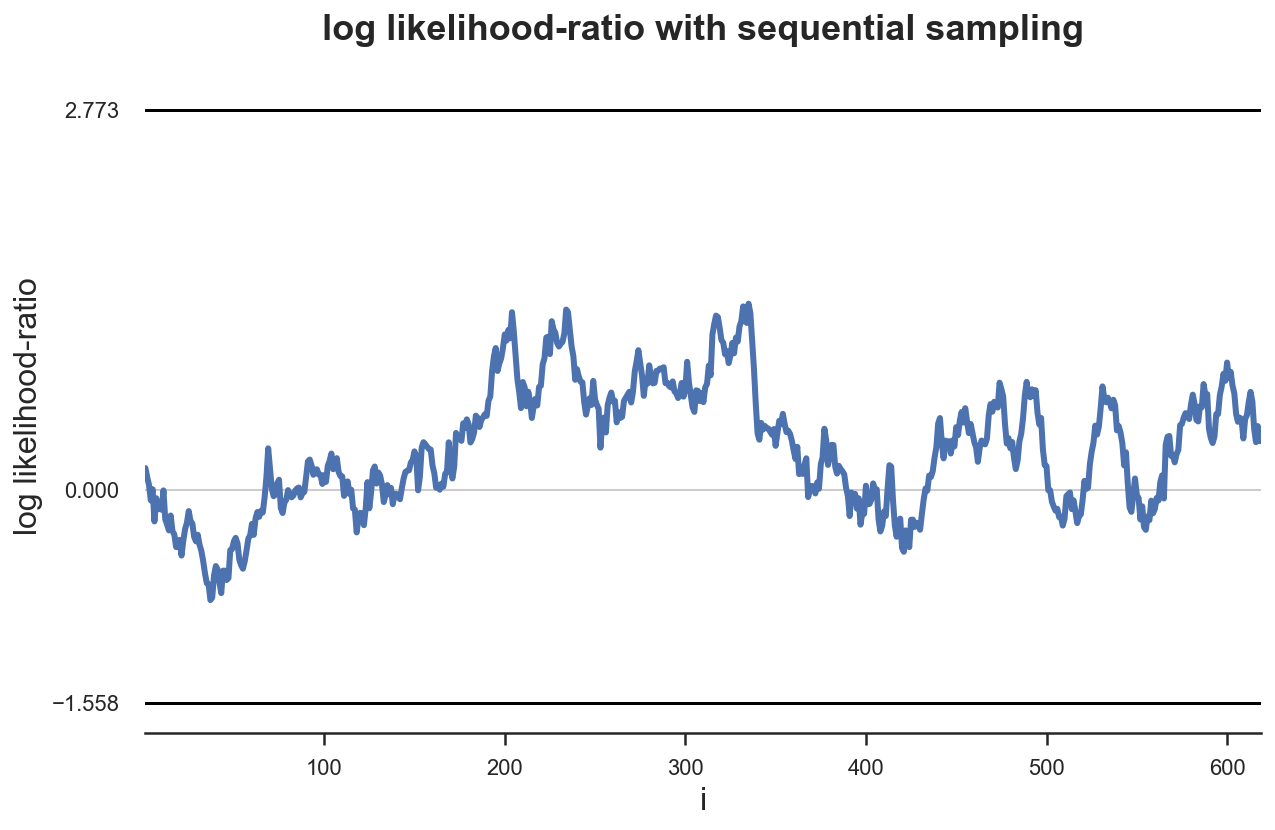

In [26]:
plot_experiment(df, ybounds=[a,b])

In this particular case, the test is inconclusive within our sampling framework. We need to **collect more data** in order to come to a decision.

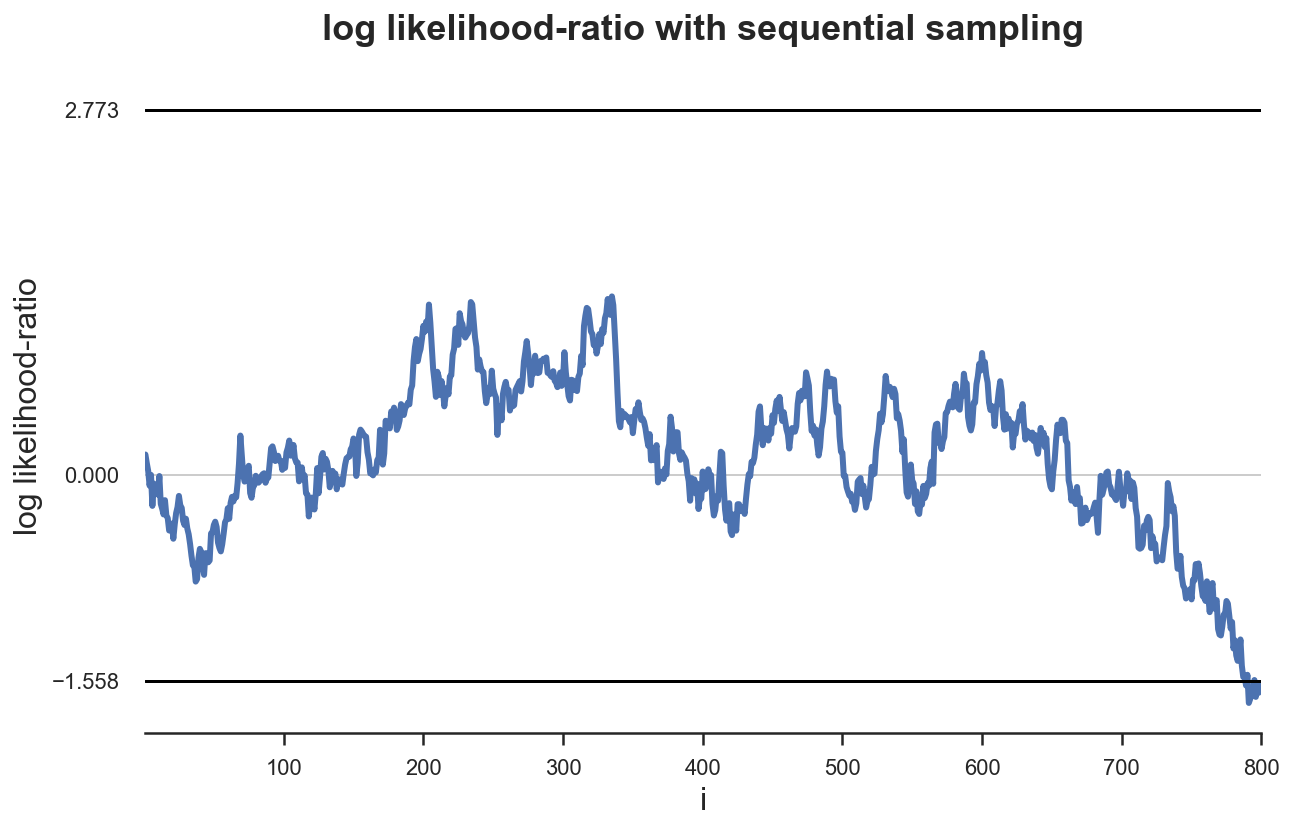

In [28]:
plot_experiment(experiment(log_lr, n=800), ybounds=[a,b]);

It takes 800 observations to reach to a conclusion, while before the sample size was 619. This test procedure seems much more lengthy than the previous one. Is it true on average?

What would happen if we were to repeat the experiment $K=100$ times?

Bounds crossed: 91 (4% upper, 96% lower)
Average experiment duration: 253


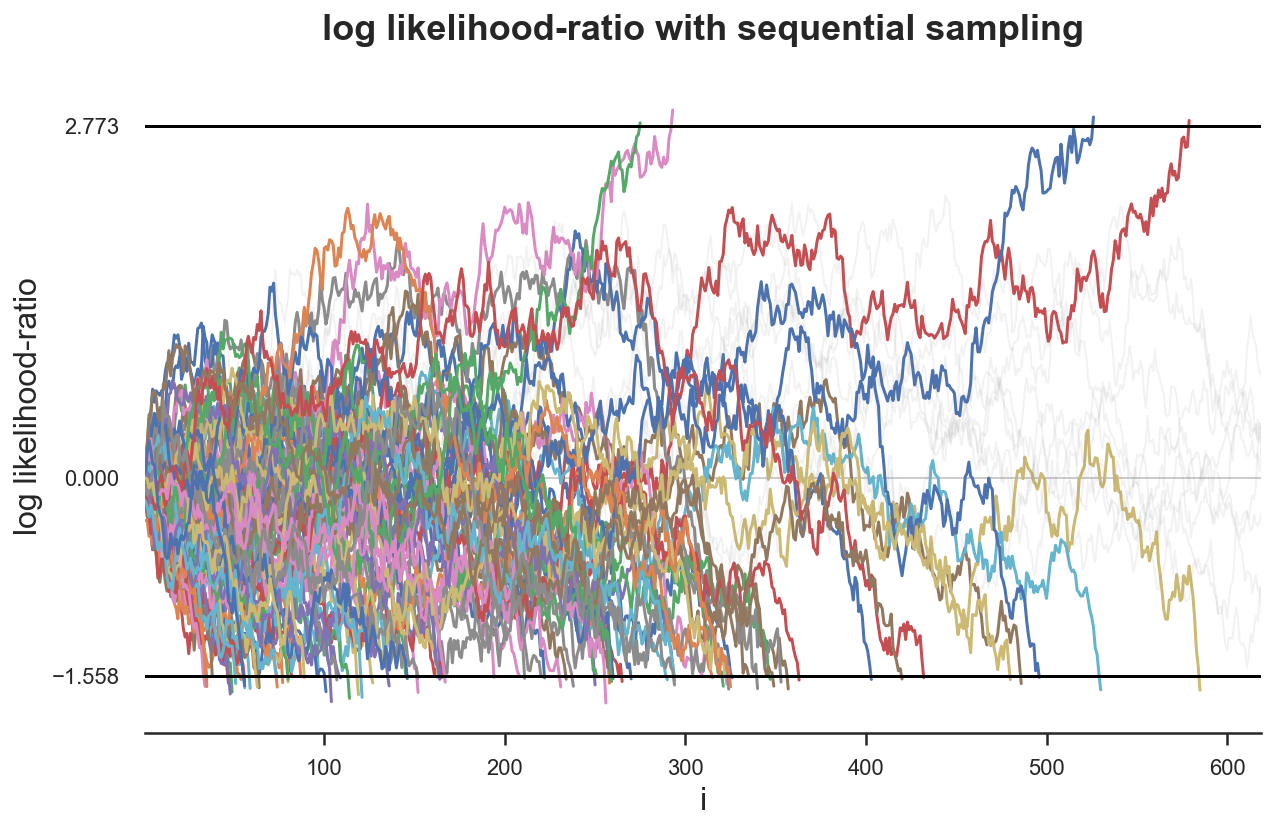

In [29]:
simulate_experiments(log_lr, ybounds=[a, b], early_stop=True, lw=1.5);

We get a decision for 91 simulations out of 100 and for 96% of them, it's the correct decision. Therefore, our rejection rate is very close to the expected $\alpha=0.05$ (under the null hypothesis).

However, for 9 experiments, the test is inconclusive. What would happen if we were to sample until we reach a conclusion in each experiment?

Bounds crossed: 100 (4% upper, 96% lower)
Average experiment duration: 275


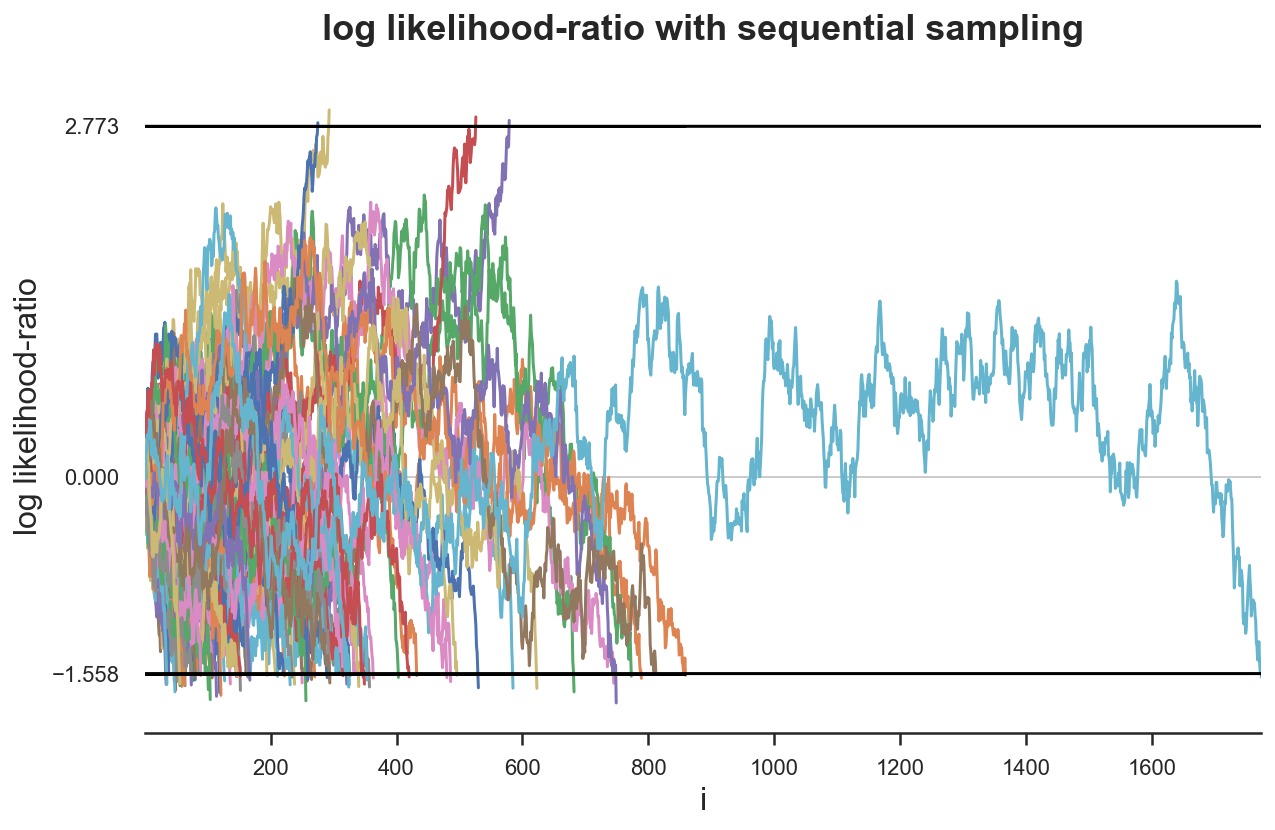

In [30]:
simulate_experiments(log_lr, ybounds=[a,b], early_stop=True, lw=1.5, n=1900);

As we can see from the plot, in one particularly unlucky experiment, we need to collect 1900 observations before coming to a conclusion. However, despite this outlier, the **average experiment duration** is an astounding 275 samples, less than half of the original sample size of 619.

What would happen if instead the alternative hypothesis $H_1: \mu = 0.1$ was true?

Bounds crossed: 100 (84% upper, 16% lower)
Average experiment duration: 443


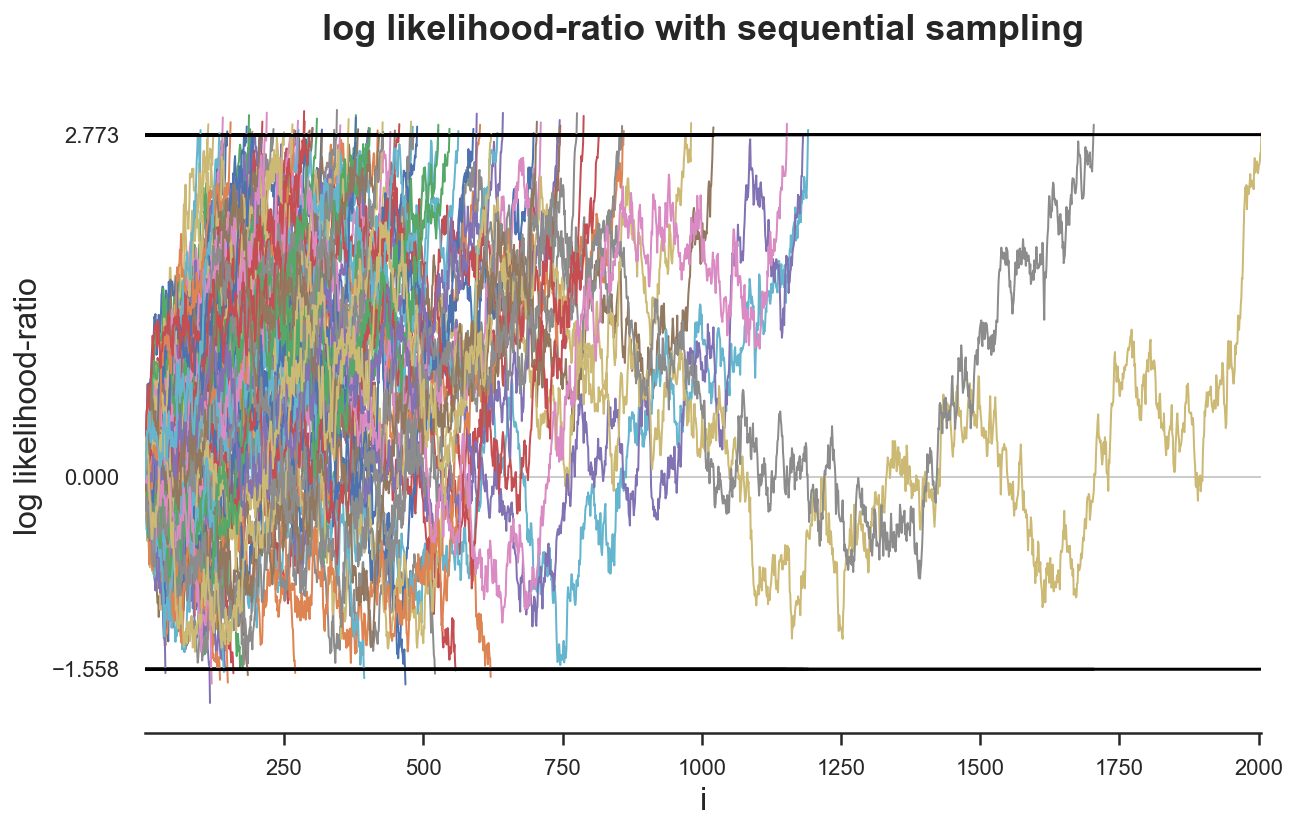

In [31]:
simulate_experiments(log_lr, ybounds=[a,b], early_stop=True, mu=0.1, lw=1, n=2100);

In this case, we make the correct decision in only 84% of the simulations, which is very close to the expected value of 80% (under the alternative hypothesis), i.e. the power of the experiment, 1-β.

Moreover, also under the alternative hypothesis we need a significantly lower sample size: just 443 observation, on average.h a conclusion in 78/100 experiments we need just 1/3 of the samples!

## Conclusion

In this post, we have seen the dangers of **peeking** during a randomized experiment. Prematurely stopping a test can be dangerous since it distorts inference, biasing the expected rejection rates.

Does it mean that we always need to perform tests with a pre-specified sample size? No! There exist procedures that allow for optimal stopping. These procedures were born for a specific purpose: reducing the sample size as much as possible, without sacrificing accuracy. The first and most known is the Sequential Probability Ratio Test, defined by Wallis as "*the most powerful and
seminal statistical ideas of the past third of a century*" (in 1980).

The SPRT was not only a powerful tool during war time but keeps being used today for very practical purposes (see for example [Netflix](https://netflixtechblog.com/improving-experimentation-efficiency-at-netflix-with-meta-analysis-and-optimal-stopping-d8ec290ae5be), [Uber](https://eng.uber.com/xp/)).

## References

[1] A. Wald, [Sequential tests of statistical hypotheses](https://www.jstor.org/stable/2235829) (1945), *The Annal of Mathematical Statistics*.

[2] A. Wald and J Wolfowitz, [Optimum character of the sequential probability ratio test](https://www.jstor.org/stable/2235638) (1948), *The Annals of Mathematical Statistics*.

[3] W. A. Wallis, [The Statistical Research Group, 1942–1945](https://www.tandfonline.com/doi/abs/10.1080/01621459.1980.10477469) (1980), *Journal of the American Statistical Association*.

You can find the original Jupyter Notebook here: https://github.com/matteocourthoud/Blog-Posts/blob/main/optimal_stopping.ipynb